## Installations and Downloads
We need to download and install PyTorch XLA to run on TPUs. The TIMM library is also installed to have access to their implementation of Vision Transformer (ViT). Likewise, we will be pulling TIMM's JAX-converted weights which have been ported to PyTorch.

In [ ]:
!curl -s https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null 2>&1
!python pytorch-xla-env-setup.py --version 1.7 > /dev/null 2>&1

In [ ]:
!pip install -Uq timm > /dev/null 2>&1
!wget -q https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl
import timm
import gc
import os
import time
import random
from datetime import datetime
from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection

## Seeding and TPU Parallelization
To begin with, we will seed everything since most of these methods are non-deterministic. Seeding would allow us to reproduce the results. Then, we will make our TPU computation more efficient by using BF16 and allocate larger memory for tensors.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(41)

In [ ]:
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

## Constants
We will also declare several global variables which defines the hyperparameters such as batch size, learning rate, number of epochs, etc. This also includes the paths to the necessary files (images, pretrained weights) and what each label corresponds to.

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-5
N_EPOCHS = 2

In [ ]:
ID2LABEL = {
    0: "Mask is worn correctly, covers the nose and mouth.",
    1: "Mask covers the mouth, but does not cover the nose.",
    2: "Mask is on, but does not cover the nose or mouth",
    3: "No mask on the face",
}

In [ ]:
DATA_PATH = "../input/medical-masks-part1/images/"
DF_PATH = "../input/medical-masks-part1/df.csv"
MODEL_PATH = "./jx_vit_base_p16_224-80ecf9dd.pth"

Also, we found out that there are corrupted images that don't work with the Pillow library, so we will remove them later during preprocessing.

In [ ]:
CORRUPTED_IMAGES = [
    "000030_1_000030_NONE_29.jpg",
    "007790_1_005591_NONE_27.jpg",
    "009065_2_006163_MALE_21.jpg",
    "009065_3_006163_MALE_21.jpg",
]

## Data Loading
The dataset provides us with a helper dataframe, which contains additional information about the image such as the gender and age of the person, as well as other metadata. We will inspect a few details that will be needed for the pre-processing step.

In [ ]:
df = pd.read_csv(DF_PATH)
df.head()

,ID,TYPE,USER_ID,GENDER,AGE,name,size_mb
0,1,1,1,MALE,25,000001_1_000001_MALE_25.jpg,1.801298
1,1,2,1,MALE,25,000001_2_000001_MALE_25.jpg,1.738558
2,1,3,1,MALE,25,000001_3_000001_MALE_25.jpg,1.799667
3,1,4,1,MALE,25,000001_4_000001_MALE_25.jpg,1.740264
4,2,1,2,MALE,23,000002_1_000002_MALE_23.jpg,1.549695


As shown above, the path to the images are provided in the `name` column, while the labels are contained in the `TYPE` column.

In [ ]:
df.describe()

,ID,TYPE,USER_ID,AGE,size_mb
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,5000.500000,2.500000,2924.691300,26.995400,2.144702
std,2886.787417,1.118048,1869.438379,21.350915,1.508811
min,1.000000,1.000000,1.000000,18.000000,0.006141
25%,2500.750000,1.750000,1245.750000,21.000000,1.135371
50%,5000.500000,2.500000,2865.000000,25.000000,1.738557
75%,7500.250000,3.250000,4450.250000,30.000000,2.769736
max,10000.000000,4.000000,6508.000000,2019.000000,11.110311


There are four different label values, corresponding to the four possible types/categories of mask. Later, we will turn these into tensors and since tensors are indexed from zero, we will decrement them by one.

In [ ]:
df["TYPE"].unique()

array([1, 2, 3, 4])

In [ ]:
df["TYPE"] = df["TYPE"].apply(lambda x: x - 1)

Recall that we still need to remove several corrupted images from the dataset, what I'll do instead is remove them from the dataframe so that they won't be loaded to PyTorch later on.

In [ ]:
for idx, img in enumerate(df.name.values):
    if img in CORRUPTED_IMAGES:
        df = df.drop(idx)

Also, for convenience of data loading in PyTorch later on, we will prepend the parent path of these images.

In [ ]:
df["name"] = df["name"].apply(lambda x: DATA_PATH + x)

Also for the convenience of dataloading in PyTorch later on, we will drop the unnecessary columns.

In [ ]:
drop_columns = ["ID", "USER_ID", "GENDER", "AGE", "size_mb"]
df = df.drop(columns=drop_columns)

Here's how the resultant dataframe looks like.

In [ ]:
df

,TYPE,name
0,0,../input/medical-masks-part1/images/000001_1_0...
1,1,../input/medical-masks-part1/images/000001_2_0...
2,2,../input/medical-masks-part1/images/000001_3_0...
3,3,../input/medical-masks-part1/images/000001_4_0...
4,0,../input/medical-masks-part1/images/000002_1_0...
...,...,...
39995,3,../input/medical-masks-part1/images/009999_4_0...
39996,0,../input/medical-masks-part1/images/010000_1_0...
39997,1,../input/medical-masks-part1/images/010000_2_0...
39998,2,../input/medical-masks-part1/images/010000_3_0...


### Subset Splitting
Finally, we will also split the dataset for training and validation/evaluation. The evaluation subset is how we ensure that our model is not overfitting.

In [ ]:
train_df, test_df = model_selection.train_test_split(
    df, test_size=0.2, random_state=42
)

## PyTorch Dataset
To support training in PyTorch, we will need to define our own subclass to their `Dataset` class. This is where we will define the length of the dataset and what happens when the dataloader indexes into our dataset. The length is as simple as the length of the dataframe, while indexing into the dataset (defined by `__getitem__`) is where we will return the image-label pair. We load the image using PIL, and the label is simply the value of `TYPE` in the dataframe. Additionally, we will add the option to apply image transforms, which will become handy later during the augmentation step.

In [ ]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df.values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label, image = self.df[index]
        image = Image.open(image)

        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

Below is an example of indexing into the dataset we defined.

In [ ]:
x, y = MaskDataset(df)[0]

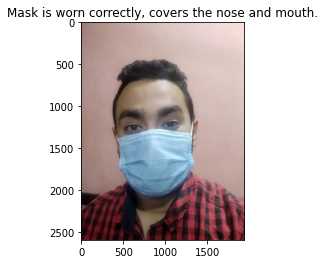

In [ ]:
plt.imshow(x)
plt.title(ID2LABEL[y])
plt.show()

### Data Augmentation
Then, we will need to define several augmentations which will help our model generalize better during training. For instance, we can do so by applying random horizontal and vertical flips, and randomly crop them while still maintaining the size. Augmentations are necessary because if we think about it, if we see someone flipped vertically/horizontally, we should still recognize whether or not they wear their mask properly (as humans). Other than that, we will apply the normalization (from pre-trained ImageNet mean and average, since we will use a pre-trained model) and of course, turning them into tensors and finally resizing them. However, we don't apply the augmentation to the validation step, since that part would only be inference and does not require additional generalization.

Note: there is test-time augmentation, but we don't think it's necessary here.

In [ ]:
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

With these defined, we can port our dataframes into the appropriate datasets for PyTorch.

In [ ]:
train_dataset = MaskDataset(train_df, transforms=transforms_train)
valid_dataset = MaskDataset(test_df, transforms=transforms_valid)

## PyTorch DataLoader
Another important part in training with PyTorch is defining dataloaders. This is especially useful as we will use batching to speed up training. Dataloaders also help for shuffling the training dataset and offloading the dataloading method into multiple workers. On top of that, since we will be leveraging all 8 TPU cores provided by Kaggle, we also need to parallelize/distribute them. Such process is facilitated by PyTorch's `DistributedSampler` to which we need define the number of available cores and the rank of each core. Since we will be using multi-TPU, it will be much more efficient if our batches are of the same size, and hence we need to drop the last batch if it's not a multiple of our defined batch size, during training.

In [ ]:
train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True,
)

valid_sampler = torch.utils.data.distributed.DistributedSampler(
    valid_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False,
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    drop_last=True,
    num_workers=4,
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    sampler=valid_sampler,
    drop_last=True,
    num_workers=4,
)

To visualize a sample batch, I will create a dummy dataloader on CPU just for visualization purposes.

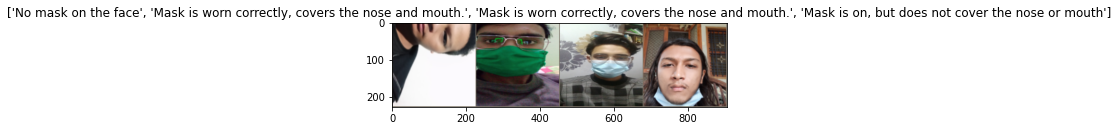

In [ ]:
import torchvision

dummy_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=4,
    num_workers=0,
)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(dummy_loader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[ID2LABEL[x.item()] for x in classes])

## Vision Transformer Model
Next, we will create a model in PyTorch, which is a subclass of their `nn.Module` class. There are a few core things to define, such as what happens in the `forward` method, and how we are going to extend this model. Extending the model is as simple as replacing the head layer with a `Linear` layer that projects the penultimate output to the number of possible classes. We also load the pretrained model weights obtained from TIMM. In the forward pass, the input `x` is simply passed to that model.

Additionally, we will define the training and validation loop from within this model class, for convenience. The training loop follows the regular PyTorch training routine:

1. Putting the model to train mode.
2. Moving data to the accelerator of choice (GPU/TPU).
3. Zeroing the optimizer gradients.
4. Performing a forward pass.
5. Calculating the loss.
6. Performing a backward pass.
7. Applying the update step through the optimizer.

Logs of training (e.g. loss, accuracy) are also saved for tracking purposes.

The validation loop is very much similar to training, with the removal of all the optimization step and only performing a forward pass (inference) on eval mode.

In [ ]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, model_path=None):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if model_path:
            self.model.load_state_dict(torch.load(model_path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            optimizer.zero_grad()
            output = self.forward(data)
            loss = criterion(output, target)
            loss.backward()

            accuracy = (output.argmax(dim=1) == target).float().mean()

            epoch_loss += loss
            epoch_accuracy += accuracy

            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        valid_loss = 0.0
        valid_accuracy = 0.0

        self.model.eval()
        for data, target in valid_loader:
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                output = self.model(data)
                loss = criterion(output, target)

                accuracy = (output.argmax(dim=1) == target).float().mean()

                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [ ]:
n_classes = len(train_df["TYPE"].unique())
model = ViTBase16(n_classes, MODEL_PATH)

In [ ]:
model

ViTBase16(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (n

### Criterion/Loss, Device, Optimizer
A few additional parts are required for training, such as the loss function (also called criterion), the accelerator device (in this case TPU), and the optimizer, where we use the Adam optimizer, which is generally more stable and faster than SGD (debatable, of course). We will move the model to the accelerator and also spike the learning rate by the number of cores we have. The learning rate spiking is optional, but the practice is often performed in a multi-core setup.

In [ ]:
criterion = nn.CrossEntropyLoss()

device = xm.xla_device()

model = ViTBase16(n_classes, MODEL_PATH)

lr = LR * xm.xrt_world_size()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Model Fitting
Here, we will then use those aforementioned components and define the model fitting procedure. The code is mostly logging, but the core steps are simply:

1. Moving the dataloader as a ParallelLoader.
2. Perform the training step.
3. Validate the model after each epoch.

We log and keep track a few stuff like loss and accuracies, and also save the best model (here, defined when the validation loss decreases). We will return those logs.

In [ ]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )
                xm.save(model.state_dict(), "best_model.pth")

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

## Train!
Here we will define the function where the training routine and everything involved are invoked. This is also the function that will be parallelized/forked into the parallel cores. Note: we re-define a few things since it's necessary for us to parallelize them too. The "flying" variables we defined above are simply for demonstration purposes.

In [ ]:
def preprocess_dataframe(df, drop_columns, corrupted_images):
    df = df.drop(columns=drop_columns)

    for idx, img in enumerate(df.name.values):
        if img in corrupted_images:
            df = df.drop(idx)

    df["TYPE"] = df["TYPE"].apply(lambda x: x - 1)
    df["name"] = df["name"].apply(lambda x: DATA_PATH + x)

    return df


def get_augmentations(image_size):
    transforms_train = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomResizedCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )

    transforms_valid = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )

    return transforms_train, transforms_valid

In [ ]:
def _run():
    df = pd.read_csv(DF_PATH)
    drop_columns = ["ID", "USER_ID", "GENDER", "AGE", "size_mb"]
    df = preprocess_dataframe(df, drop_columns, CORRUPTED_IMAGES)

    train_df, test_df = model_selection.train_test_split(
        df, test_size=0.2, random_state=42
    )

    n_classes = len(train_df["TYPE"].unique())

    transforms_train, transforms_valid = get_augmentations(IMG_SIZE)
    train_dataset = MaskDataset(train_df, transforms=transforms_train)
    valid_dataset = MaskDataset(test_df, transforms=transforms_valid)

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True,
    )

    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=4,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=True,
        num_workers=4,
    )

    criterion = nn.CrossEntropyLoss()

    device = xm.xla_device()

    model = ViTBase16(n_classes, MODEL_PATH)
    model.to(device)

    lr = LR * xm.xrt_world_size()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )

Below is simply a PyTorch XLA function that we will pass to the TPUs when they spawn.

In [ ]:
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    _run()

In [ ]:
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method="fork")

2021-12-24 16:32:16.975926: I torch_xla/csrc/tensor_util.cpp:28] Using BF16 data type for floating point values


INITIALIZING TRAINING ON 8 TPU CORES
Start Time: 2021-12-24 16:32:18.292817


2021-12-24 16:32:19.326957: I torch_xla/csrc/tensor_util.cpp:28] Using BF16 data type for floating point values


2021-12-24 16:32:19.644107: I torch_xla/csrc/tensor_util.cpp:28] Using BF16 data type for floating point values


EPOCH 1 - TRAINING...


2021-12-24 16:32:22.828296: I torch_xla/csrc/tensor_util.cpp:28] Using BF16 data type for floating point values
2021-12-24 16:32:25.724735: I torch_xla/csrc/tensor_util.cpp:28] Using BF16 data type for floating point values
2021-12-24 16:32:25.831110: I torch_xla/csrc/tensor_util.cpp:28] Using BF16 data type for floating point values
2021-12-24 16:32:26.270057: I torch_xla/csrc/tensor_util.cpp:28] Using BF16 data type for floating point values
2021-12-24 16:32:26.396955: I torch_xla/csrc/tensor_util.cpp:28] Using BF16 data type for floating point values


	BATCH 1/125 - LOSS: 1.4609375
	BATCH 21/125 - LOSS: 0.294921875
	BATCH 41/125 - LOSS: 0.32421875
	BATCH 61/125 - LOSS: 0.234375
	BATCH 81/125 - LOSS: 0.1767578125
	BATCH 101/125 - LOSS: 0.234375
	BATCH 121/125 - LOSS: 0.21875

	[TRAIN] EPOCH 1 - LOSS: 0.330078125, ACCURACY: 0.9140625

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 0.1064453125, ACCURACY: 0.984375

EPOCH 2 - TRAINING...
	BATCH 1/125 - LOSS: 0.1787109375
	BATCH 21/125 - LOSS: 0.326171875
	BATCH 41/125 - LOSS: 0.1494140625
	BATCH 61/125 - LOSS: 0.2236328125
	BATCH 81/125 - LOSS: 0.09716796875
	BATCH 101/125 - LOSS: 0.1484375
	BATCH 121/125 - LOSS: 0.203125

	[TRAIN] EPOCH 2 - LOSS: 0.1953125, ACCURACY: 0.96875

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 0.09228515625, ACCURACY: 0.9765625

Validation loss decreased (0.1064 --> 0.0923).  Saving model ...
Execution time: 1:50:17.016098
Saving Model
